# Setup training data

In [1]:
import pandas as pd
import numpy as np

import keras
from keras import backend as K

import glob
import cv2
import os

from matplotlib import pyplot as plt
import random

2024-05-28 13:36:17.676514: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 13:36:17.676775: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 13:36:17.888806: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def pixel_decode(px: int, rows: int) -> (int, int):
    x = (px - 1) // rows
    y = (px - 1) % rows
    return x, y

# rle = run-length encoding
def rle2mask(rle_string, shape):
    rle_list = list(map(int, rle_string.split()))
    
    decoded_pixels = np.zeros(shape, dtype=np.float32)
    rows = shape[0]
    for i in range(0, len(rle_list), 2):
        rle_px = rle_list[i]
        pixel_count = rle_list[i + 1] - 1
        
        x, y = pixel_decode(rle_px, rows)
        
        decoded_pixels[y:y+pixel_count, x] = 1
    
    return decoded_pixels

def generate_masks(df, image_id, shape):
    pixel_masks = []
    for class_id in range(1, 5):        
        image_defects = df[(df['ImageId'] == image_id) & (df['ClassId'] == class_id)]
        if image_defects.empty:
            pixel_mask = np.zeros(shape, dtype=np.float32)
        else:
            rle_pixel = str(image_defects['EncodedPixels'].iloc[0])
            pixel_mask = rle2mask(rle_pixel, shape)
            
        pixel_masks.append(pixel_mask)
    
    return np.stack(pixel_masks, axis=-1)

In [3]:
num_images = 12568
image_shape = (128, 800)

# masks
train_df = pd.read_csv("/kaggle/input/severstal-steel-defect-detection/train.csv")
train_df.head()

# images
train_image_base_path = "/kaggle/input/severstal-steel-defect-detection/train_images/"
train_image_file_extension = "*.jpg"
train_image_path = os.path.join(train_image_base_path, train_image_file_extension)
train_image_names = [os.path.basename(path) for path in glob.glob(train_image_path)]
train_image_names.sort()

train_image_subset = train_image_names[0:num_images]
train_image_dataset = np.array(train_image_subset)

In [4]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, path, image_ids, validation_df, new_dim = (128, 800, 3), resize_factor = 2, batch_size = 16, n_classes = 4, shuffle=True):
        super().__init__()
        self.path = path
        self.image_ids = image_ids
        self.validation_df = validation_df
        self.dim = new_dim
        self.resize_factor = resize_factor
        self.batch_size = batch_size
        self.n_classes = n_classes
        self.shuffle = shuffle
        
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.image_ids) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        # Generate one batch of data
        indexes = self.indexes[index * self.batch_size:(index+1)*self.batch_size]
        
        list_ids_temp = [self.image_ids[k] for k in indexes]
        
        X, y = self.__data_generation(list_ids_temp)
        
        return X, y
        
    def __data_generation(self, list_ids_temp):
        # Initialization
        height = self.dim[0]
        width = self.dim[1]
        X = np.empty((self.batch_size, *self.dim), dtype=np.float32)
        y = np.empty((self.batch_size, height, width, self.n_classes), dtype=np.float32)
        
        for i, image_id in enumerate(list_ids_temp):
            image_path = os.path.join(self.path, image_id)
            image = cv2.imread(image_path, 1)
            resized_image = cv2.resize(image, (width, height), interpolation=cv2.INTER_NEAREST)
            normalized_image = resized_image / 255.0
            X[i,] = normalized_image
            
            masks = generate_masks(self.validation_df, image_id, (height * self.resize_factor, width * self.resize_factor))
            resized_masks = [cv2.resize(masks[:,:,j], (width, height), interpolation=cv2.INTER_NEAREST) for j in range(self.n_classes)]
            y[i,] = np.stack(resized_masks, axis=-1)
            
            
        return X, y        

In [8]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [6]:
idx = int(0.8*len(train_image_dataset))

validation_batches = DataGenerator(
    train_image_base_path,
    train_image_dataset[idx:],
    train_df,
    shuffle=False
)

# Load trained model

In [9]:
from keras.models import load_model 

model = load_model("models/steel_defect_detection_12000.h5",
                  custom_objects={'dice_coef': dice_coef})

# Check the result (by looking at random samples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


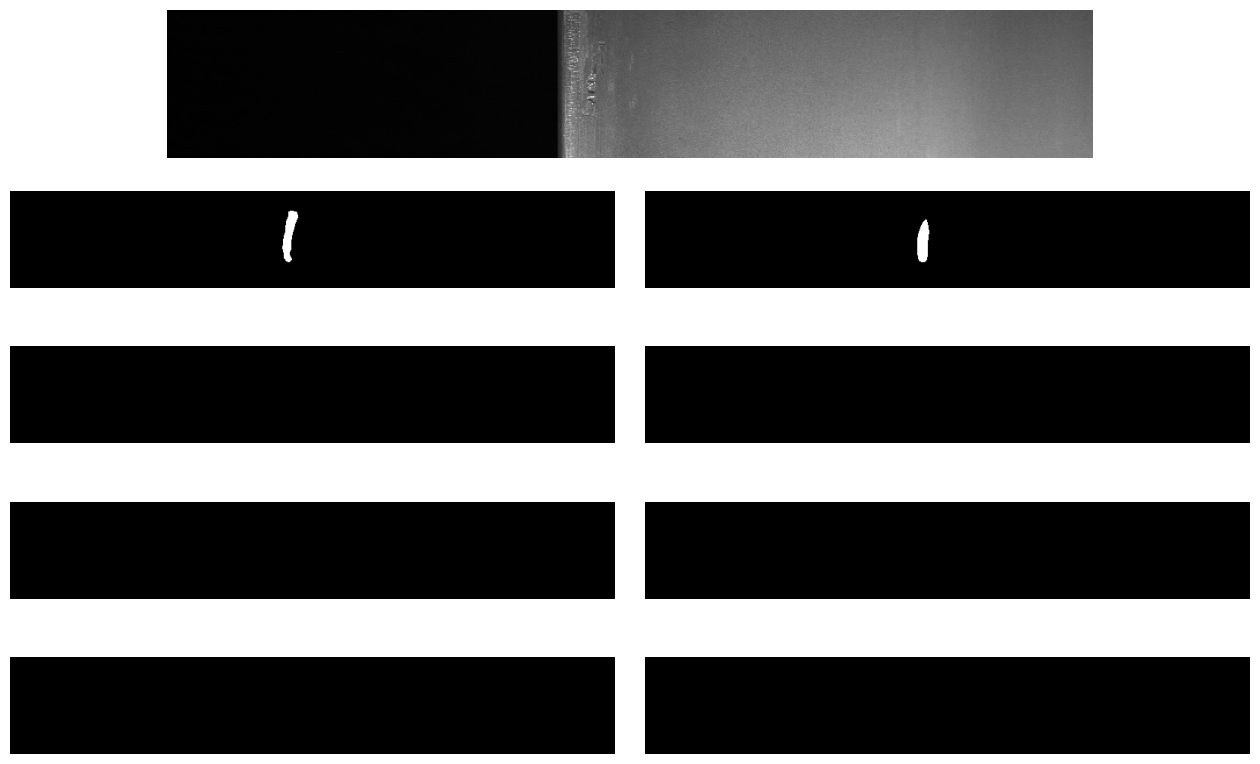

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


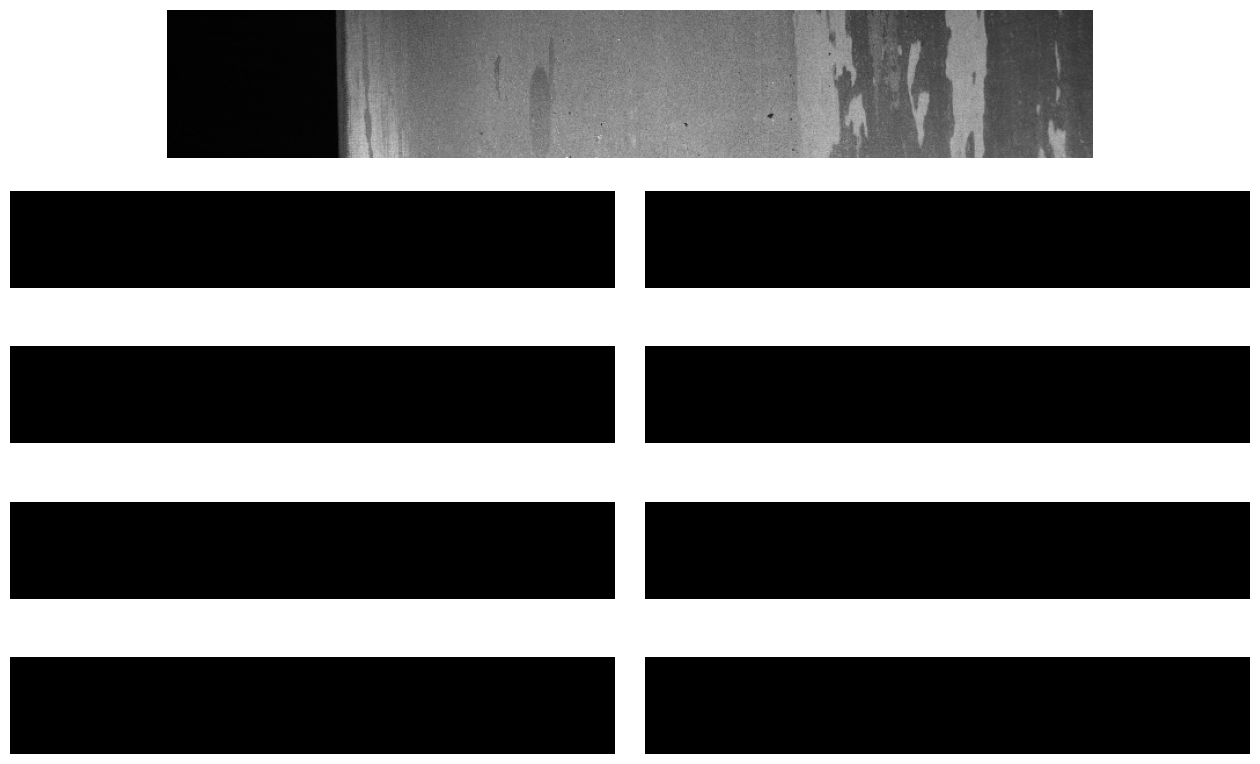

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


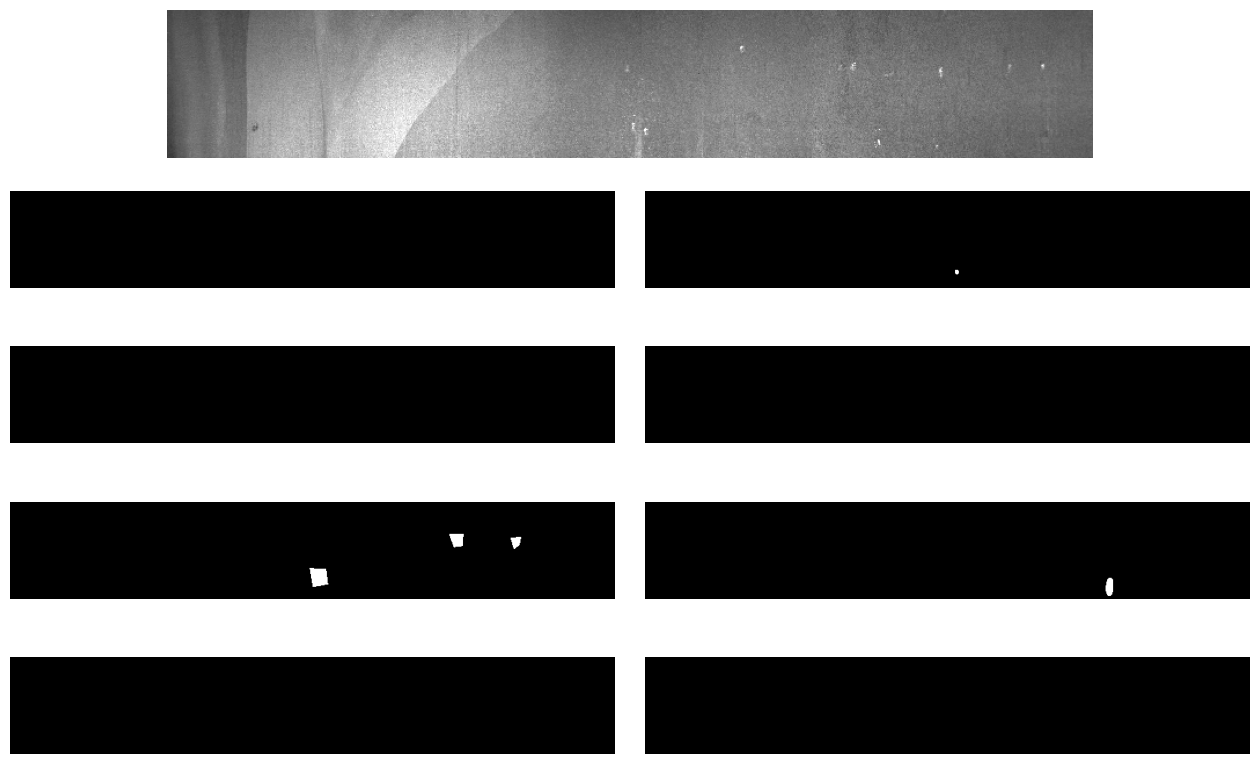

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


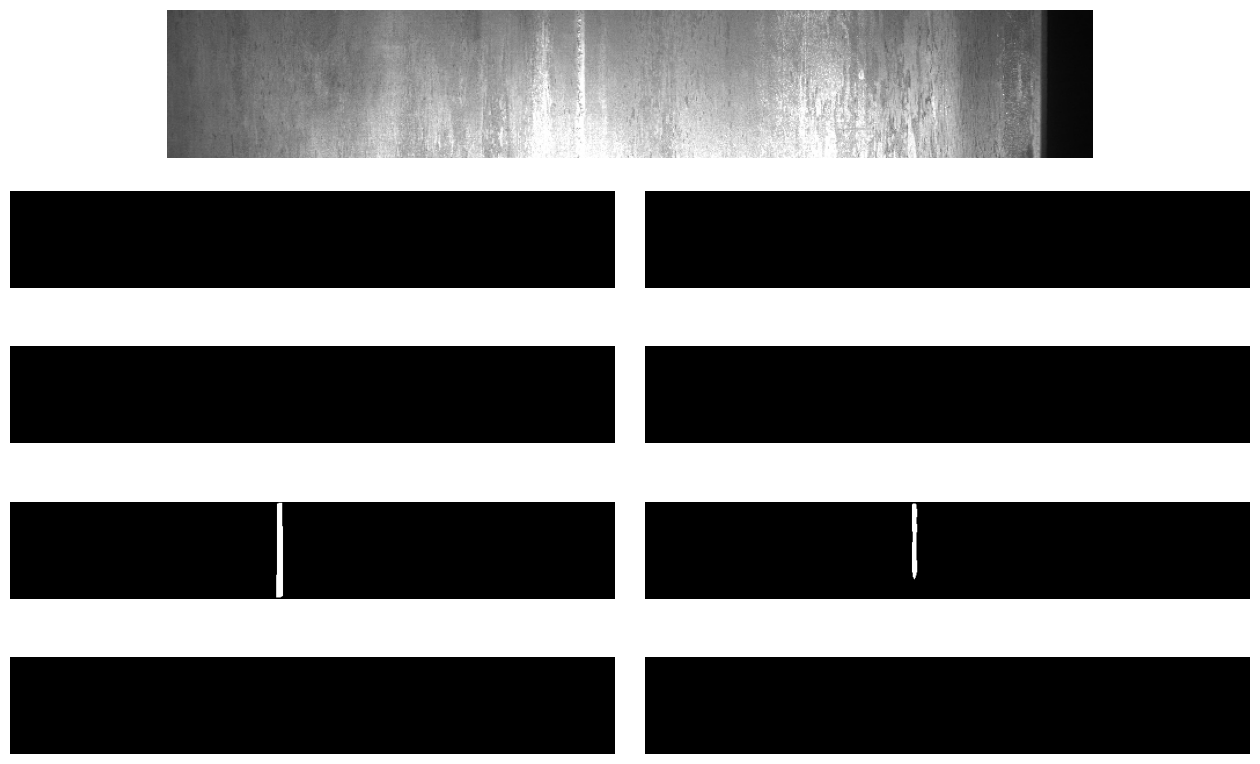

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


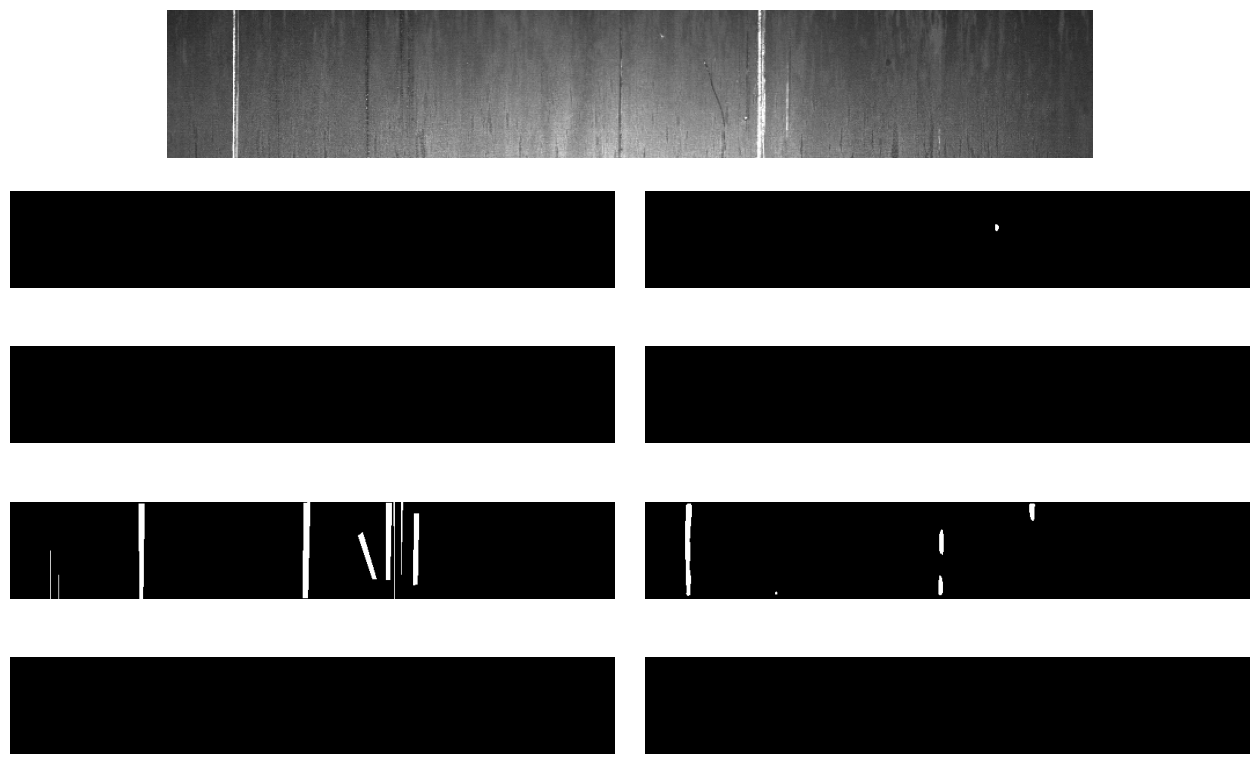

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


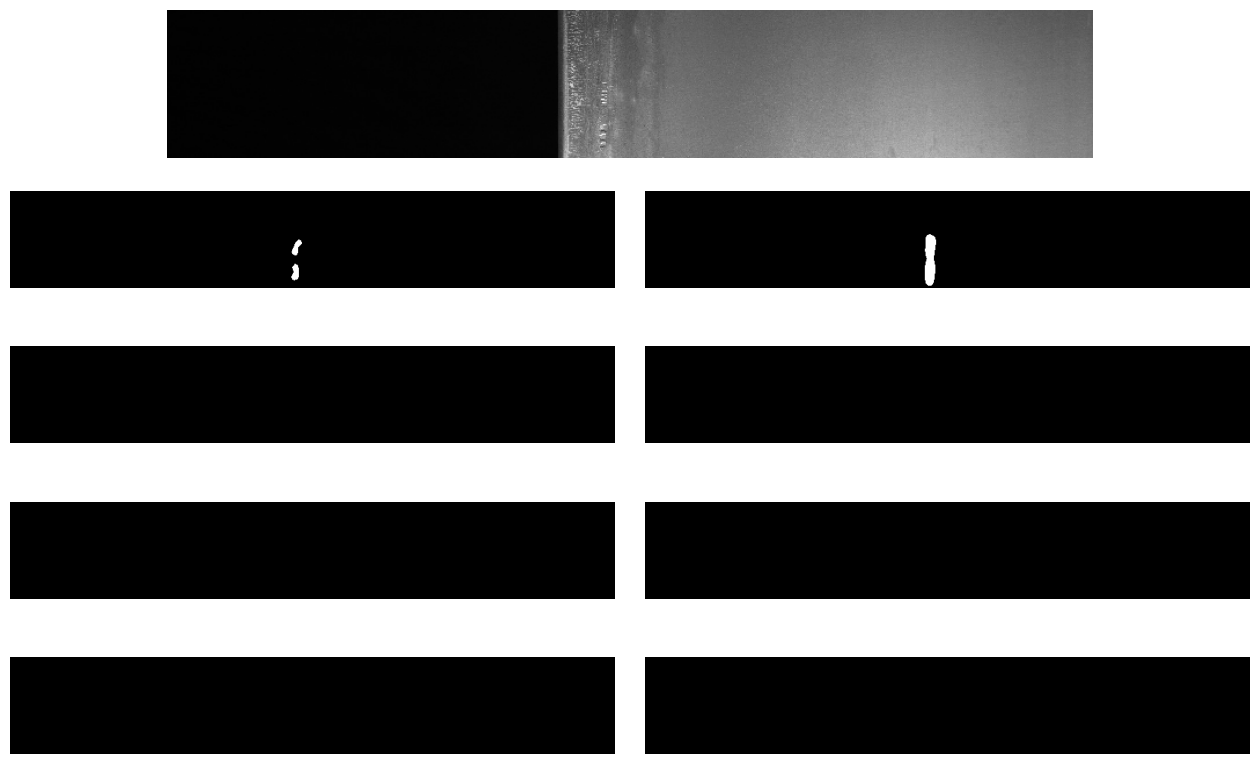

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


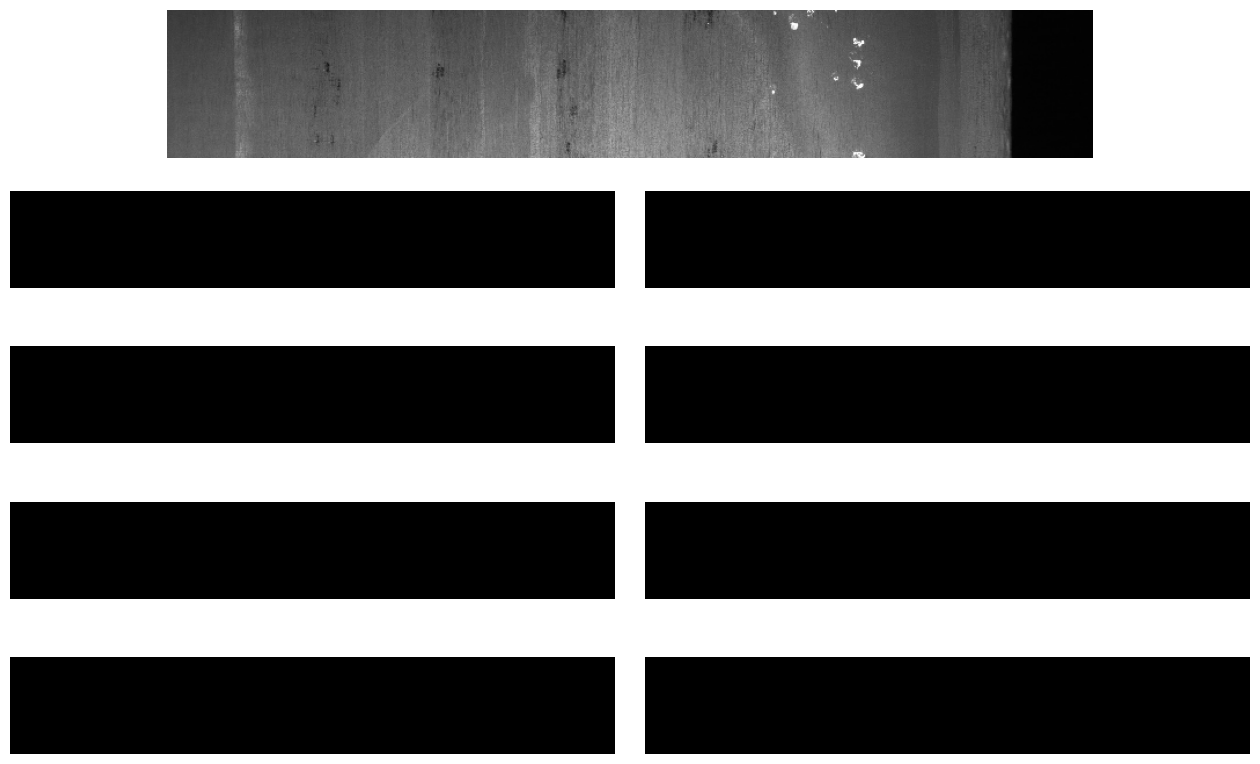

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


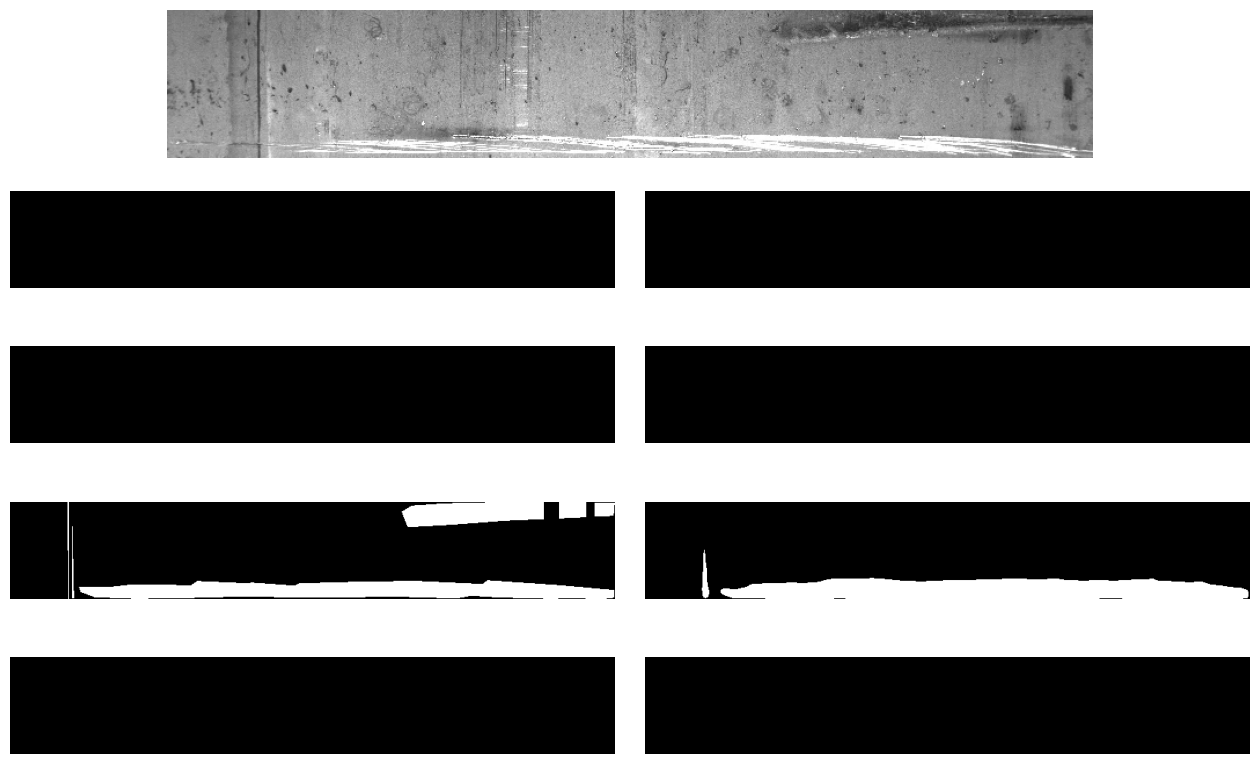

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


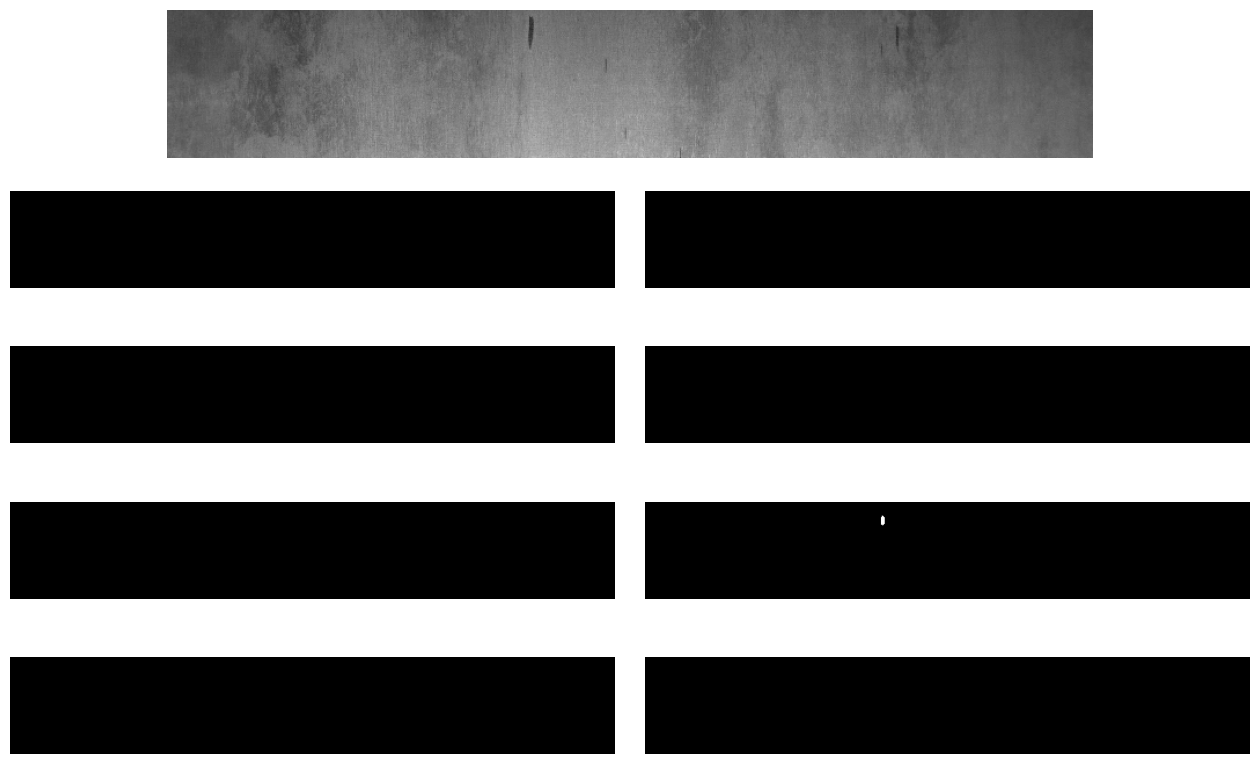

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


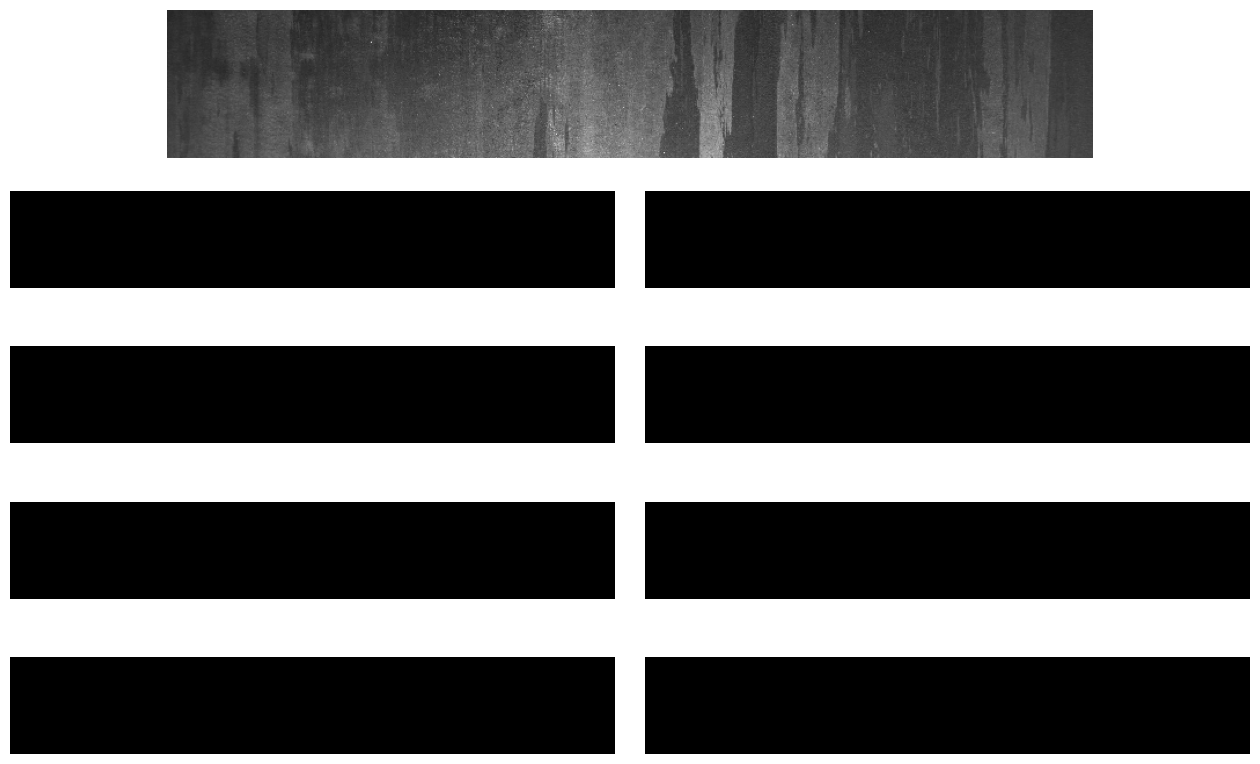

In [34]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import random

for _ in range(10):
    test_batch_number = random.randint(0, len(validation_batches) - 1)
    test_img_number = random.randint(0, 15)
    test_img = validation_batches[test_batch_number][0][test_img_number]
    test_img_reshape = test_img.reshape(1, 128, 800,3)
    ground_truth = validation_batches[test_batch_number][1][test_img_number]
    prediction = model.predict(test_img_reshape)
    binary_prediction = (prediction >= 0.5).astype(int)

    fig = plt.figure(figsize=(16, 10))

    gs = gridspec.GridSpec(5, 2, height_ratios=[1, 1, 1, 1, 1]) 

    # Display test_img in the first row
    ax0 = plt.subplot(gs[0, :])  
    ax0.imshow(test_img, cmap="gray") 
    ax0.axis('off')  

    # Display ground truth images
    for i in range(4): 
        ax = plt.subplot(gs[i+1, 0])
        ax.imshow(ground_truth[:,:,i], cmap="gray") 
        ax.axis('off')  

    # Display binary prediction images
    for i in range(4): 
        ax = plt.subplot(gs[i+1, 1])
        ax.imshow(binary_prediction[0,:,:,i], cmap="gray")
        ax.axis('off')  

    # Adjust subplot spacing
    plt.subplots_adjust(hspace=0.05, wspace=0.05)
    plt.show()
